# Using CorrHOD

### What does it do ?

In [18]:
import sys 
sys.path.append('../../CorrHOD/')
from CorrHOD.cubic import CorrHOD_cubic
from pathlib import Path

import matplotlib.pyplot as plt
from pycorr import project_to_multipoles

The CorrHOD class needs only the HOD parameters, the cosmology and the path to the config file to be initialized. The HOD parameters have to be provided in a dictionnary, as follows. An `array_to_dict` function can be found in the `utils` module.

A line of sight can also be provided. The tracer for this code is meant to be BGS or LRG, which use the same ???? in AbacusHOD. Other tracers can be used by redefining the tracer parameter within the class.

In [19]:
HOD_params = {
    'logM_cut': 12.0,
    'logM1':    14.525, 
    'sigma':    0.029, 
    'alpha':    1.141, 
    'kappa':    1.089, 
    'alpha_c':  0.0, 
    'alpha_s':  0.0, 
    'Bcent':    0.0, 
    'Bsat':     0.0
}

path2config = Path('../config/config.yaml');

In [20]:
# Initialize the CorrHOD object
Object = CorrHOD_cubic(HOD_params, path2config)
Object.data_params['tracer_density_mean'][Object.tracer] = 5e-4 # See run_all section below to understand this modification

First, we need to initialize the dark matter simulation. This requires to have already run the `prepare_sim` script from AbacusHOD.

If this has not already be done, an error will be raised. An example of the `prepare_sim` script is given in the ./scripts folder.

In [21]:
Object.initialize_halo();

Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

Then, we populate the halos with galaxies using the HOD parameters. This will give us the galaxy catalog.

In [22]:
mock_dict = Object.populate_halos();

gen mocks 0.5932149887084961


If the parameters we choose are correct, the code should return a number density identical to the one we want. Since it is constrained by this value, we want to check that we have a good number density.

A check is already implemented in the `populate_halos` method, that will raise a warning if the number density of the box is not close enough of the constraint, if `data_params` is in the config file (with a gap of the std provided as the error)

In [23]:
# Get the number density in the object to check we get the expected value
boxsize = 2000 # Mpc/h
Ngal = Object.cubic_dict['LRG']['x'].shape[0]
n = Ngal/(boxsize**3)

# Expected number density that should constrains the HOD parameters
if Object.data_params is not None:
    expected_n = Object.data_params['tracer_density_mean']['LRG']
    print(f'Number density: {n:.2e} ({expected_n:.2e} expected)')
else:
    print(f'Number density: {n:.2e}')

Number density: 5.00e-04 (5.00e-04 expected)


To be able to compute correlations functions, we need positions in redshift space. the `get_tracer_positions` method applies the Redshift Space Distorsions (RSD) along the line of sight (los) defined in the initialization of the class ('z' by default)

In [24]:
data_positions = Object.get_tracer_positions();

Then, we can compute the two-point correlation function of the tracer.

The `compute_2pcf`method returns a `pycorr.XXX` object, which contains the correlation function. However, the CorrHOD class stores the separation bin centers and multipoles in a dictionary, which can be accessed as self.CF[los] (los being the computed line of sight), with the following keys:

- 's': separation bin centers
- '2PCF': poles of the correlation function

(Other keys will be used later)

In [25]:
xi = Object.compute_2pcf();

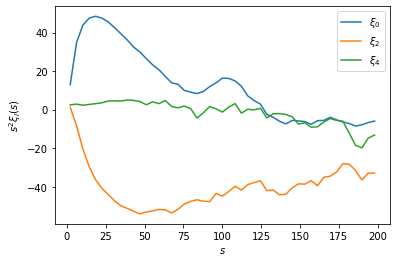

In [26]:
s, poles = project_to_multipoles(xi)

plt.plot(s, poles[0]*s**2, label=r'$\xi_0$')
plt.plot(s, poles[1]*s**2, label=r'$\xi_2$')
plt.plot(s, poles[2]*s**2, label=r'$\xi_4$')
plt.legend()

plt.xlabel(r'$s$')
plt.ylabel(r'$s^2\xi_l(s)$');

We also can compute the densitysplit (see https://github.com/epaillas/densitysplit/tree/master) on the data. 
Here, we take the defaults parameters of the compute_DensitySplit method, i.e. a radius of 10 Mpc/h, and a cell size of 5 Mpc/h.

*Note : The arguments to call this method can change depending on the dneitysplit branch used. Here, we use the openmp branch, which allows multithreading ans is MPI-compatible.*

In [27]:
nquantiles=10
density, quantiles = Object.compute_DensitySplit(nquantiles=nquantiles);

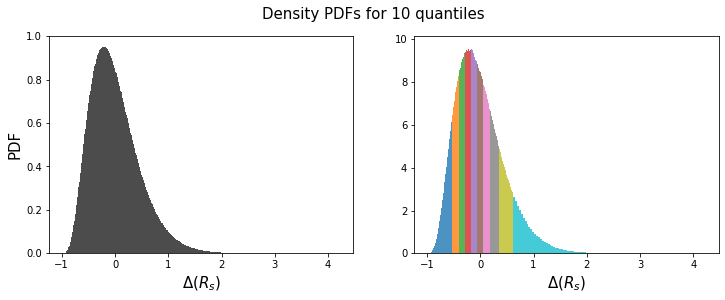

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the quantiles density
from pandas import qcut
density_quantiles = []
q_cut = qcut(density, nquantiles, labels=False) 

for i in range(nquantiles):
    density_quantiles.append(density[q_cut == i])
    ax[1].hist(density_quantiles[i], bins=100, density=True, alpha=0.8, label=f'Q{i}')

ax[0].hist(density, bins=500, density=True, alpha=0.7, color='k')

ax[0].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[1].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[0].set_ylabel('PDF', fontsize=15)
fig.suptitle(f'Density PDFs for {nquantiles} quantiles', fontsize=15);

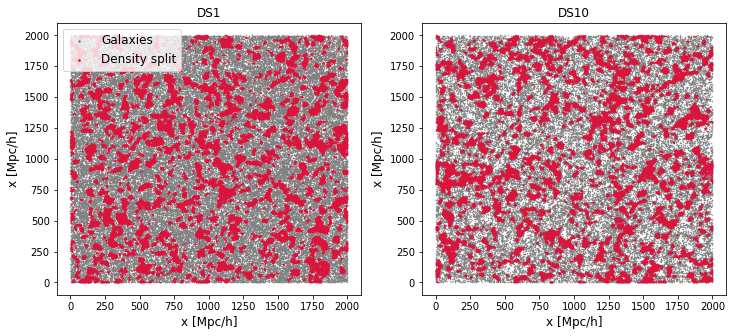

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
boxsize = 2000

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')

for i, ids in enumerate([0, nquantiles-1]):
    cut = quantiles[ids][:, 2] < 50

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1], s=0.1, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids + 1}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
#     ax[i].set_xlim(0, boxsize)
#     ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show();

We then can compute the auto and cross correlation of the quantiles with the data. Like the 2PCF, the results are also stored in the self.CF dictionnary. We consider that the edges of the separation bins are the same as the 2PCF.
* The poles of the autocorrelation of the i-th quantileare saved in self.CF[los]['Auto'][DS{i}] 
* The poles of the coross-correlation of the i-th quantile are saved as self.CF[los]['Cross'][DS{i}] 


In [30]:
xi_auto = Object.compute_auto_corr(9)
xi_cross = Object.compute_cross_corr(9);

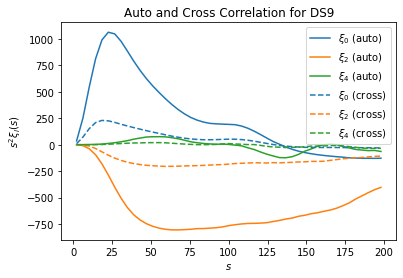

In [31]:
s1, poles1 = project_to_multipoles(xi_auto)
s2, poles2 = project_to_multipoles(xi_cross)

# The separation s can be accessed with : (s1 and s2 are the same since the same edges are used for both auto and cross)
s1 = Object.CF['z']['s']
s2 = Object.CF['z']['s']

# The poles can also be accessed with : 
poles1 = Object.CF['z']['Auto']['DS9']
poles2 = Object.CF['z']['Cross']['DS9']

plt.plot(s1, poles1[0]*s1**2, label=r'$\xi_0$ (auto)', color='C0')
plt.plot(s1, poles1[1]*s1**2, label=r'$\xi_2$ (auto)', color='C1')
plt.plot(s1, poles1[2]*s1**2, label=r'$\xi_4$ (auto)', color='C2')

plt.plot(s2, poles2[0]*s2**2, label=r'$\xi_0$ (cross)', ls='--', color='C0')
plt.plot(s2, poles2[1]*s2**2, label=r'$\xi_2$ (cross)', ls='--', color='C1')
plt.plot(s2, poles2[2]*s2**2, label=r'$\xi_4$ (cross)', ls='--', color='C2')

plt.legend()
plt.xlabel(r'$s$')
plt.ylabel(r'$s^2\xi_l(s)$');
plt.title('Auto and Cross Correlation for DS9');

### The `run_all` method

This method is implemented ro run all the computation in one go. All the arguments are described in the docstring of the method.
Since every information is stored in the class, we can access the results of the computation in the same way as before.

A logger is also implemented in the class, and more specifically in the `run_all` method. This can be really useful to see what happens during the execution. Most of the outputs are logged on the INFO level, but some less important are logged on DEBUG level. The logger can be initialized with the create_logger function in the utils package, and the setup_logging function from mockfactory can be used before that to display the logs of other loggers within called functions (like the 2pcf of pycorr).

From this point, we can restart the kernel and run the following cells to see how to use the `CorrHOD_cubic` class.

*Note : We artificially reduce the number density to speed up the computation otherwise it takes too long for a BGS-like sample in a notebook. That this will make the CFs noisier on large scales*

In [2]:
import sys 
sys.path.append('../../CorrHOD/')
from CorrHOD.cubic import CorrHOD_cubic
from pathlib import Path

from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

from CorrHOD.utils import create_logger
from mockfactory import setup_logging

# Get a logger object
setup_logging() # Initialize the logging for all the loggers that will not have a handler 
logger = create_logger('CorrHOD', level='debug', stream=sys.stdout)

HOD_params = {
    'logM_cut': 12.0,
    'logM1': 14.525, 
    'sigma': 0.029, 
    'alpha': 1.141, 
    'kappa': 1.089, 
    'alpha_c': 0.0, 
    'alpha_s': 0.0, 
    'Bcent': 0.0, 
    'Bsat': 0.0
}

nquantiles=10

path2config = Path('../config/config.yaml')

# Get the number of threads available
import multiprocessing
nthread = multiprocessing.cpu_count()
print(f'Number of threads available: {nthread}')

Object = CorrHOD_cubic(HOD_params, path2config)

# We artificially reduce the number density to speed up the computation 
Object.data_params['tracer_density_mean'][Object.tracer] = 1e-4 

Object.run_all(nquantiles=nquantiles, nthread=nthread)

Number of threads available: 256
Running CorrHOD with the following parameters (0) :
	 Simulation : AbacusSummit_base_c000_ph000
	 logM_cut : 12.0
	 logM1 : 14.525
	 sigma : 0.029
	 alpha : 1.141
	 kappa : 1.089
	 alpha_c : 0.0
	 alpha_s : 0.0
	 Bcent : 0.0
	 Bsat : 0.0
	 Number density : 1.00e-04 h^3/Mpc^3

Initializing and populating the halos ...
Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation

/global/u1/s/sbouchar/Abacus_HOD/CorrHOD/examples/../../CorrHOD/CorrHOD/cubic.py:1047: UserWarning: Unknown argument display_times=True in run_all. It will be ignored.
  warn(f'Unknown argument {key}={value} in run_all. It will be ignored.', UserWarning)


Here is an example of the plots that can be output after the `run_all` method. Since run_all computes all lines of sight and averages them, we can plot the average of the CFs : 

*Note: We notice the noise on large scales due to the low number density. This is already improved by averaging on the three lines of sight*

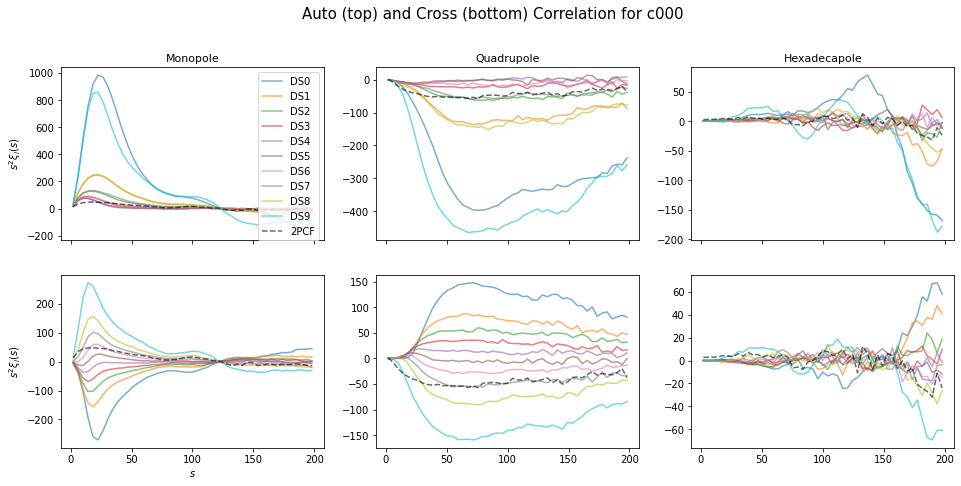

In [3]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(16, 7))

colors = [f'C{i}' for i in range(nquantiles)]

s = Object.CF['average']['s'] # Get the separation s (identical for all CFs)

for i in range(nquantiles):
    
    color = colors[i]
    alpha = 0.6
    
    # Plot the multipoles of the auto correlation
    poles1 = Object.CF['average']['Auto'][f'DS{i}']
    ax[0,0].plot(s, poles1[0]*s**2, alpha=alpha, color=color, label = f'DS{i}')
    ax[0,1].plot(s, poles1[1]*s**2, alpha=alpha, color=color)
    ax[0,2].plot(s, poles1[2]*s**2, alpha=alpha, color=color)

    # Plot the multipoles of the cross correlation
    poles2 = Object.CF['average']['Cross'][f'DS{i}']
    ax[1,0].plot(s, poles2[0]*s**2, alpha=alpha, color=color)
    ax[1,1].plot(s, poles2[1]*s**2, alpha=alpha, color=color)
    ax[1,2].plot(s, poles2[2]*s**2, alpha=alpha, color=color)
    
#Add the 2PCF on both plots

poles = Object.CF['average']['2PCF']
for i in [0, 1]:
    ax[i,0].plot(s, poles[0]*s**2, alpha=alpha, color='k', ls='--', label='2PCF')
    ax[i,1].plot(s, poles[1]*s**2, alpha=alpha, color='k', ls='--')
    ax[i,2].plot(s, poles[2]*s**2, alpha=alpha, color='k', ls='--')


ax[0,0].legend()
ax[1,0].set_xlabel(r'$s$')
ax[1,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_title('Monopole', fontsize=11)
ax[0,1].set_title('Quadrupole', fontsize=11)
ax[0,2].set_title('Hexadecapole', fontsize=11)
fig.suptitle('Auto (top) and Cross (bottom) Correlation for c000', fontsize=15, y=1);

The `run_all` method times every step of the execution. these times are displayed in the logs, but are also stored in a times_dict object, that can be accessed.

In [4]:
# Access the times

# The times are stored in a dictionary
times_dict = Object.times_dict

# It contains the following keys:
pprint(times_dict)

# Let's compute some interesting times to look at

total_time = times_dict['run_all']

mean_los_time = np.mean([times_dict[los]['run_los'] for los in ['x', 'y', 'z']], axis=0)

mean_2PCF_time = np.mean([times_dict[los]['compute_2pcf'] for los in ['x', 'y', 'z']], axis=0)

mean_auto_time = np.mean([times_dict[los]['compute_auto_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)

mean_cross_time = np.mean([times_dict[los]['compute_cross_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)

total_auto_time = np.mean([np.sum([times_dict[los]['compute_auto_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)

total_cross_time = np.mean([np.sum([times_dict[los]['compute_cross_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)

#Display the times
print(f'Total time: {total_time:.2f} s')

print(f'Mean time for computing a LOS: {mean_los_time:.2f} s')

print(f'Mean time for computing the 2PCF: {mean_2PCF_time:.2f} s')

print(f'Mean time for computing an auto correlation: {mean_auto_time:.2f} s')

print(f'Mean time for computing a cross correlation: {mean_cross_time:.2f} s')

print(f'Mean time for computing all auto correlations: {total_auto_time:.2f} s')

print(f'Mean time for computing all cross correlations: {total_cross_time:.2f} s')



{'initialize_halo': 68.41348338127136,
 'run_all': 1460.7061595916748,
 'x': {'compute_2pcf': 16.01204538345337,
       'compute_DensitySplit': 3.7917423248291016,
       'compute_auto_corr': {'DS0': 14.334765434265137,
                             'DS1': 15.238130331039429,
                             'DS2': 15.153738498687744,
                             'DS3': 14.371912956237793,
                             'DS4': 15.349670648574829,
                             'DS5': 14.840091705322266,
                             'DS6': 14.998621702194214,
                             'DS7': 15.503707885742188,
                             'DS8': 14.519324779510498,
                             'DS9': 13.904168367385864},
       'compute_cross_corr': {'DS0': 27.31558060646057,
                              'DS1': 26.910293340682983,
                              'DS2': 27.25561499595642,
                              'DS3': 26.57404327392578,
                              'DS4': 26.1932606697

Finally, the `save` method allows us to save the contents of the class in .npy files that can be accessed later. See the docstring of the functions for all the saving options.

In [ ]:
# Save the elements for later
path = Path('../data')
path.mkdir(parents=True, exist_ok=True)
Object.save(path=path, save_all=True)